In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from Solver import Solver # собственный решатель

## Уравнение маятника 

Рассматривается задача анализа движения трехзвенного маятника, точка подвеса которого находится под воздействием высокочастотной вибрации. Система уравнений, описывающее движение маятника выглядит следующим образом:

$a_{11}\ddot{\varphi}_{1}+a_{12}\ddot{\varphi}_{2}+a_{13}\ddot{\varphi}_{3}+b_{1}\dot{\varphi}_{1}+c_{1}\varphi_{1}=0$

$a_{21}\ddot{\varphi}_{1}+a_{22}\ddot{\varphi}_{2}+a_{23}\ddot{\varphi}_{3}+b_{2}\dot{\varphi}_{2}+c_{2}\varphi_{2}=0$

$a_{31}\ddot{\varphi}_{1}+a_{32}\ddot{\varphi}_{2}+a_{33}\ddot{\varphi}_{3}+b_{3}\dot{\varphi}_{3}+c_{3}\varphi_{3}=0$

Сведение указанной системы уравнений к этапу использованию численных методов, заключается в представлении системы в форме Коши. 
Тогда получаем следующую систему:

$\dot{\varphi}_{1}={z}_{1}$

$\dot{\varphi}_{2}={z}_{2}$

$\dot{\varphi}_{3}={z}_{3}$

$\dot{z}_{1}={Wolfr}_1$

$\dot{z}_{2}={Wolfr}_2$

$\dot{z}_{3}={Wolfr}_3$


Где ${Wolfr}_{1,2,3}$ - развязанные уравнения относительно 2-й производной, полученные в Wolfram. Используя полученную систему, определим функции для решателя

## Функции решателя

In [8]:
@njit
def harm_force(t, p1, p2):
    return a1 * p1**2 * np.cos(p1 * t) + a2 * p2**2 * np.cos(p2 * t)

@njit
def f1(t, p1, p2):
    return S[0,0] * harm_force(t, p1, p2) * np.sin(nu_angle) / g

@njit
def f2(t, p1, p2):
    return S[1,0] * harm_force(t, p1, p2) * np.sin(nu_angle) / g

@njit
def f3(t, p1, p2):
    return S[2,0] * harm_force(t, p1, p2) * np.sin(nu_angle) / g

@njit
def c1(t, p1, p2):
    return B[0,0] * (1 + 1 / g * harm_force(t, p1, p2) * np.cos(nu_angle))

@njit
def c2(t, p1, p2):
    return B[1,1] * (1 + 1 / g * harm_force(t, p1, p2) * np.cos(nu_angle))

@njit
def c3(t, p1, p2):
    return B[2,2] * (1 + 1 / g * harm_force(t, p1, p2) * np.cos(nu_angle))

@njit
def system_du(y, t, p1, p2):
    dphi1dt = y[3]
    dphi2dt = y[4]
    dphi3dt = y[5]
    dz1dt = ((A[1,2]*A[2,1]*(f1(t, p1, p2)-c1(t, p1, p2)*y[0]-n*y[3]) \
              + A[1,1]*A[2,2]*(c1(t, p1, p2)*y[0]-f1(t, p1, p2)+n*y[3]) \
              - (A[0,2]*A[2,1]-A[0,1]*A[2,2])*(f2(t, p1, p2) \
                - c2(t, p1, p2)*y[1]-n*y[4])+A[0,2]*A[1,1]*(f3(t, p1, p2) \
                - c3(t, p1, p2)*y[2]-n*y[5])+A[0,1]*A[1,2]*(c3(t, p1, p2)*y[2]-f3(t, p1, p2) \
                + n*y[5]))/(A[0,2]*A[1,1]*A[2,0]-A[0,1]*A[1,2]*A[2,0] \
                - A[0,2]*A[1,0]*A[2,1]+A[0,0]*A[1,2]*A[2,1]+A[0,1]*A[1,0]*A[2,2]-A[0,0]*A[1,1]*A[2,2]))
    dz2dt = ((A[1,0]*A[2,2]*(f1(t, p1, p2)-c1(t, p1, p2)*y[0]-n*y[3]) \
             +A[1,2]*A[2,0]*(-f1(t, p1, p2)+c1(t, p1, p2)*y[0]+n*y[3]) \
             +(A[0,2]*A[2,0]-A[0,0]*A[2,2])*(f2(t, p1, p2) \
             -c2(t, p1, p2)*y[1]-n*y[4])+A[0,0]*A[1,2]*(f3(t, p1, p2) \
            -c3(t, p1, p2)*y[2]-n*y[5])+A[0,2]*A[1,0]*(-f3(t, p1, p2) \
            +c3(t, p1, p2)*y[2]+n*y[5]))/(A[0,2]*A[1,1]*A[2,0] \
            -A[0,1]*A[1,2]*A[2,0]-A[0,2]*A[1,0]*A[2,1] \
            +A[0,0]*A[1,2]*A[2,1]+A[0,1]*A[1,0]*A[2,2]-A[0,0]*A[1,1]*A[2,2]))
    dz3dt = ((A[1,0]*A[2,1]*(f1(t, p1, p2)-c1(t, p1, p2)*y[0]-n*y[3]) \
             +A[1,1]*A[2,0]*(-f1(t, p1, p2)+c1(t, p1, p2)*y[0]+n*y[3]) \
             +(A[0,1]*A[2,0]-A[0,0]*A[2,1])*(f2(t, p1, p2) \
            -c2(t, p1, p2)*y[1]-n*y[4])+A[0,0]*A[1,1]*(f3(t, p1, p2)-c3(t, p1, p2)*y[2] \
            -n*y[5])+A[0,1]*A[1,0]*(-f3(t, p1, p2)+c3(t, p1, p2)*y[2]+n*y[5]))/(-A[0,2] \
            *A[1,1]*A[2,0]+A[0,1]*A[1,2]*A[2,0]+A[0,2]*A[1,0]*A[2,1] \
            -A[0,0]*A[1,2]*A[2,1]-A[0,1]*A[1,0]*A[2,2]+A[0,0]*A[1,1]*A[2,2]))
    return [dphi1dt, dphi2dt, dphi3dt, dz1dt, dz2dt, dz3dt]

### Параметры маятника

In [2]:
m1 = 0.5
l1 = 3
m2 = 1
l2 = 0.7
m3 = 7
l3 = 0.06

n = 0.5
a1 = 0.006
a2 = 0.006
g = 9.8
nu_angle = 30 * np.pi / 180

T_integr = 500

In [3]:
p1 = 15 * 2 * np.pi
p2 = 20 * 2 * np.pi

## Матрицы коэффициентов

Определим матрицы коэффициентов, необходимые для последующего аналитического расчета

In [4]:
A = np.array([
    [l1**2 * (m1 + m2 + m3), l1*l2 * (m2 + m3), l1 * l3 * m3],
    [l1*l2 * (m2 + m3), l2**2 * (m2 + m3), l2 * l3 * m3],
    [l1*l3 * m3, l2*l3 * m3, l3**2 * m3]
])

In [5]:
B = np.array([
    [l1* g * (m1 + m2 + m3), 0, 0],
    [0, l2 * g * (m2 + m3), 0],
    [0, 0, l3 * g * m3]
])

In [6]:
S = np.array([
    [g * (l1 * m1 + m2 * (l1 + l2) + m3 * (l1 + l2 + l3))],
    [g * (m2 * l2 + m3 * (l2 + l3))],
    [g * l3 * m3]
])

In [7]:
R = np.linalg.inv(A).dot(B)
F = np.linalg.inv(A).dot(S)
Q = np.linalg.inv(A).dot( n * np.eye(3))

## Решение уравнений

In [9]:
sol = Solver(system_du)

In [11]:
sol.solve([0, 0, 0, 0, 0, 0], 50, 0.0001, args=(p1, p2))

In [15]:
with open('oscillytor.npy', 'wb') as f:
    np.save(f, sol.y[:, 0])
with open('time.npy', 'wb') as f:
    np.save(f, sol.t)

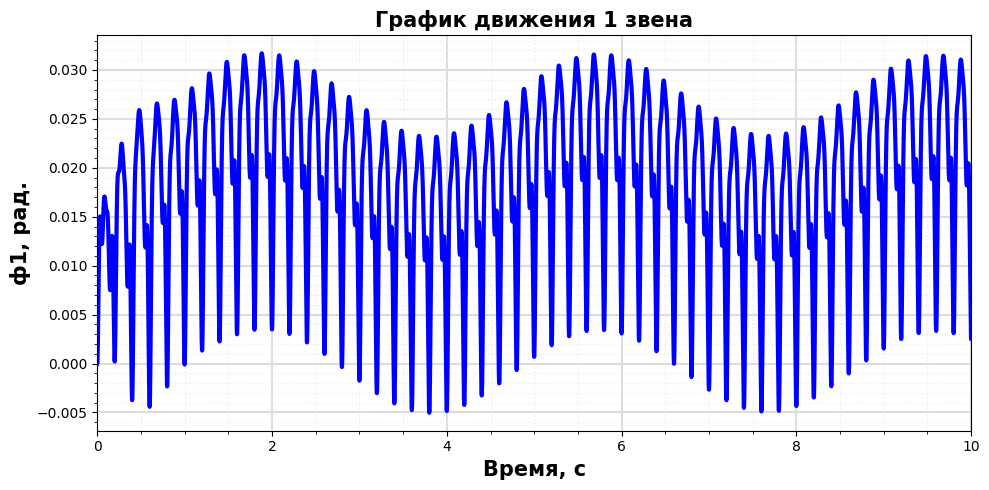

In [12]:
sol.plot_solution(0, x_scale=[0, 10], 
                   labels_name=['Время, с', 'ф1, рад.'],
                  title='График движения 1 звена',
                 fig_size=(10,5))

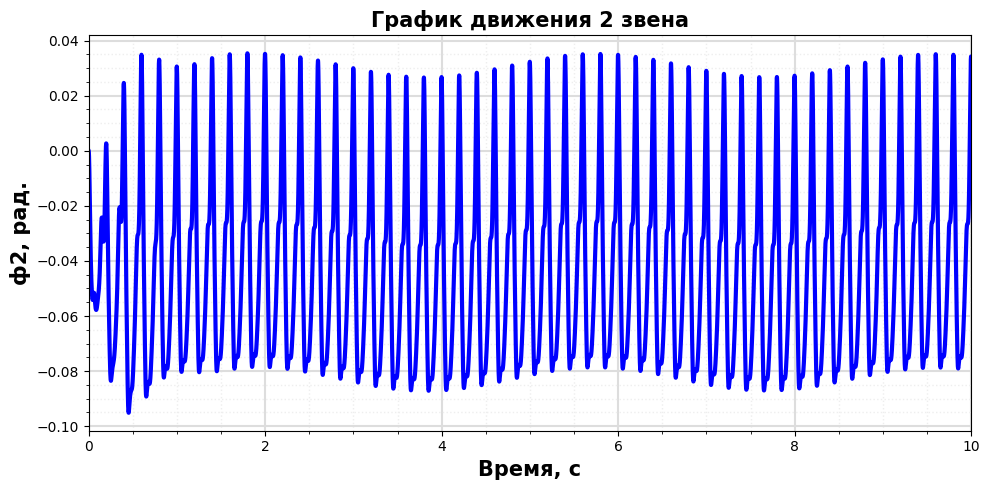

In [29]:
sol.plot_solution(1, x_scale=[0, 10], 
                   labels_name=['Время, с', 'ф2, рад.'],
                  title='График движения 2 звена',
                 fig_size=(10,5))

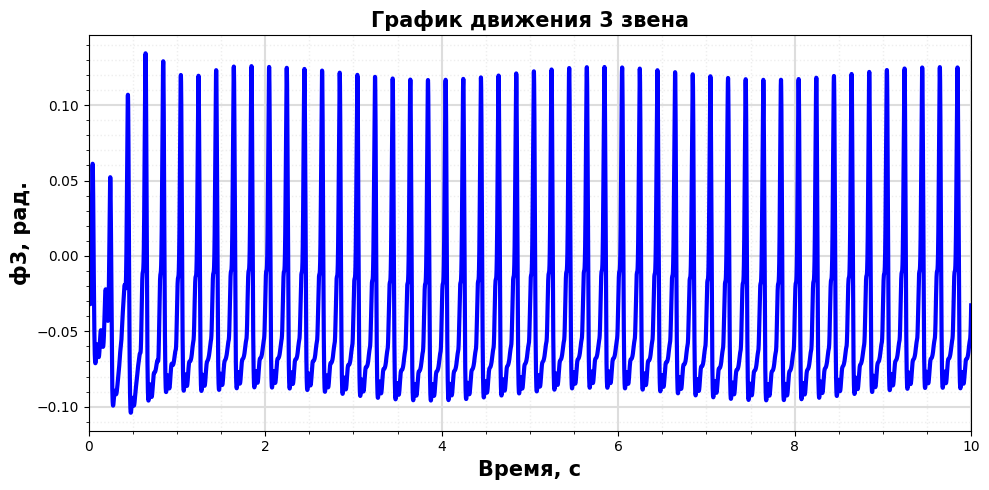

In [30]:
sol.plot_solution(2, x_scale=[0, 10], 
                   labels_name=['Время, с', 'ф3, рад.'],
                  title='График движения 3 звена',
                 fig_size=(10,5))

Text(0.5, 1.0, 'График движения всех звеньев')

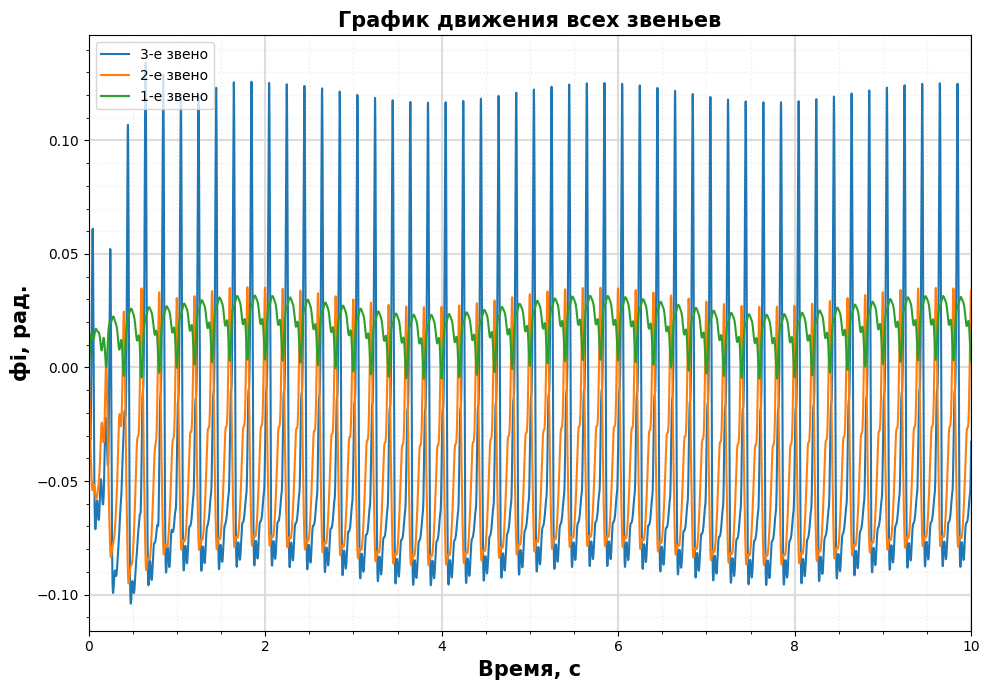

In [36]:
fig, ax = plt.subplots(figsize=(10,7), layout='tight')
        
ax.grid(which='major', color='#DDDDDD', linewidth=1.5)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
ax.minorticks_on()
ax.grid(True)
        
ax.plot(sol.t, sol.y[:, 2], linewidth=1.5, label='3-е звено')
ax.plot(sol.t, sol.y[:, 1], linewidth=1.5, label='2-е звено')
ax.plot(sol.t, sol.y[:, 0], linewidth=1.5, label='1-е звено')
ax.legend()

ax.set_xlim(0, 10)

plt.xlabel('Время, с', fontsize=15, fontweight="bold")
plt.ylabel('фi, рад.', fontsize=15, fontweight="bold")

plt.title('График движения всех звеньев', fontsize=15, fontweight="bold")